In [1]:
from util.gen_utils import *
from util.cohort_viz_util import *
from util.plot_utils import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Overview
Visualize study design, sample collection, and pregnancy outcomes for mothers included

# Load data
* Discovery dataset metadata
* Validation dataset metadata

In [2]:
meta = {'discovery' : read_sample_meta_table('../../data/rnaseq_stanford_all/discovery/sample_meta_postQC.csv'),
        'validation' : read_sample_meta_table('../../data/rnaseq_stanford_all/val/sample_meta_postQC.csv'), 
        'gapps' : read_sample_meta_table('../../data/gapps/sample_meta_postQC.csv')
       }

In [3]:
#Adjust for plotting - in DE we include a dummy GA for design matrix and a label that samples are PP
for key in meta.keys():
    meta[key].loc[meta[key].is_pp == 1, 'ga_at_collection'] = np.nan

## Visualize sample collection
* Visually understand sample collection
* Ensure that there is no stat difference in sample collection between PE and normotensive groups

In [4]:
#Check if sample collection during each period differed significantly
sample_collection_pvals = {}

for ds_name, meta_df in meta.items():
    sample_collection_pvals[ds_name] = {}
    
    if ds_name == 'gapps': #different sample coll strategy
        sample_collection_pvals[ds_name] = test_and_adj([(0, 1)], meta_df, 'case', 'ga_at_collection', 'two-sided', use_ttest = False)[0][(0,1)].round(2)
        continue
    
    for term, time_group in term_labels.items():
        if meta_df.loc[meta_df.term == term].shape[0] == 0: #For validation
            continue
        col_to_use = 'ga_at_collection' if time_group != 'Post-partum' else 'weeks_post_del' 
        sample_collection_pvals[ds_name][time_group] = test_and_adj([(0, 1)], meta_df.loc[meta_df.term == term], 'case', col_to_use, 'two-sided', use_ttest = False)[0][(0,1)].round(2)

print(sample_collection_pvals)

{'discovery': {'<= 12 weeks gestation': 0.9, '13-20 weeks gestation': 0.98, '>= 23 weeks gestation': 0.26, 'Post-partum': 0.47}, 'validation': {'<= 12 weeks gestation': 0.88, '13-20 weeks gestation': 0.65, '>= 23 weeks gestation': 0.11, 'Post-partum': 0.34}, 'gapps': 0.46}


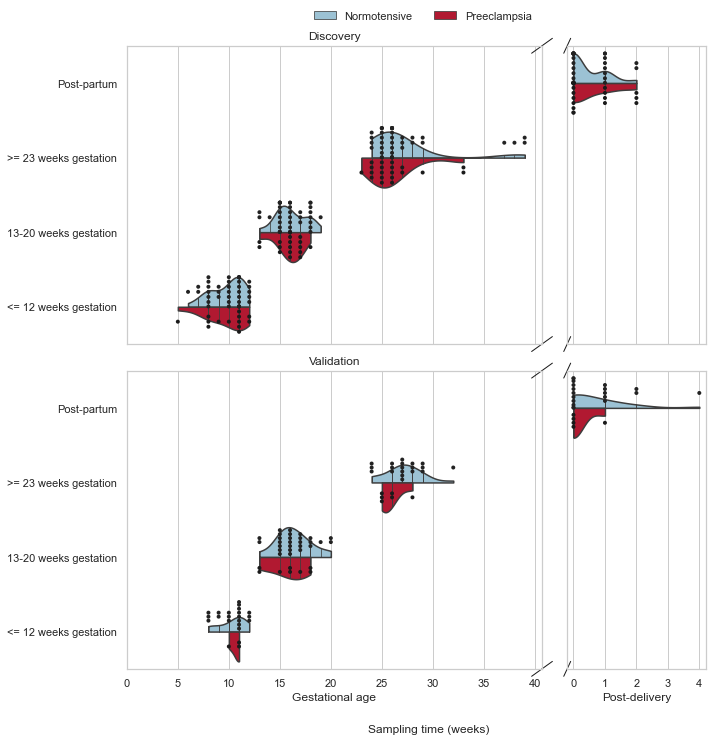

In [5]:
out_path_prefix = 'out/ds_viz/'

collection_full, ax = plot_both_discovery_val_sample_collection({key.capitalize() : {'meta' : val, 'plot_pp' : True} for key,val in meta.items() if key != 'gapps'})
save_figure_pdf(collection_full, out_path_prefix + 'GA_at_sample_collection.pdf')

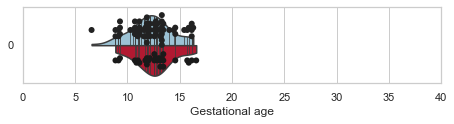

In [6]:
#Sampling strategy for GAPPs is different, using is_pp as dummy variable to plot split vp easily
gapps_collection, ax = plot_violin_and_swarmplot(meta['gapps'], x_name = 'ga_at_collection', y_name = 'is_pp', hue_name = 'case', orient = 'h', 
                          violinplot_palette = cntrl_pe_palette, x_label = 'Gestational age', y_label = '', split = True, figsize = (7.5,1.4))
ax.legend().remove()

ax.set_xlim([0,40])
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
save_figure_pdf(gapps_collection, out_path_prefix + 'GAPPs_GA_at_collection.pdf')

# Visualize if GA at delivery differs
* In either dataset

In [7]:
ga_delivery_pvals = {}
meta_subj_all = []

for ds_name, meta_df in meta.items():
    meta_subj = meta_df.drop_duplicates(subset = 'subject').copy().reset_index(drop = True).set_index('subject')
    meta_subj.insert(0, 'dataset', ds_name)
    meta_subj_all +=  [meta_subj.drop(columns = ['term', 'ga_at_collection', 'weeks_post_del'])]
    ga_delivery_pvals[ds_name] = {test_and_adj([(0, 1)], meta_subj, 'case', 'ga_wk_del', 'greater', use_ttest = False)[0][(0,1)]}

meta_subj_all = pd.concat(meta_subj_all, axis = 0)
ga_delivery_pvals

{'discovery': {6.433528536212887e-07},
 'validation': {0.03749523791222316},
 'gapps': {8.424572624345693e-09}}

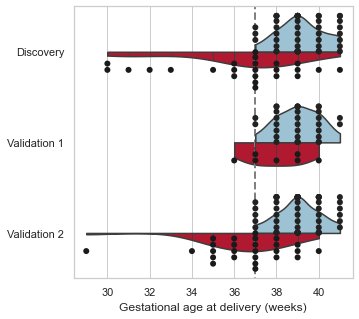

In [8]:
fig, ax = plot_violin_and_swarmplot(df = meta_subj_all, x_name = 'ga_wk_del', y_name = 'dataset', hue_name = 'case', orient = 'h', violinplot_palette = cntrl_pe_palette,
                                        x_label = 'Gestational age at delivery (weeks)', y_label = '', split = True,
                                        include_vline = True, line_pos = 37, line_start = -5, line_end = 5)
    
plt.yticks([0,1,2], ['Discovery', 'Validation 1', 'Validation 2'])
ax.get_legend().remove()
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
save_figure_pdf(fig, 'out/ds_viz/' + 'GA_at_delivery.pdf')

# Visualize if gestational age at PE onset differed between mild vs severe PE groups
* In either dataset

In [9]:
pe_onset_pvals = {}

for ds_name, meta_subj in meta_subj_all.groupby('dataset'):
    pe_onset_pvals[ds_name] = {test_and_adj([('mild', 'severe')], meta_subj.loc[meta_subj.case == 1], 'pe_feature', 'pe_onset_ga_wk', 'two-sided', use_ttest = False)[0][('mild', 'severe')].round(5)}

pe_onset_pvals

{'discovery': {0.13595}, 'gapps': {0.39868}, 'validation': {1.0}}

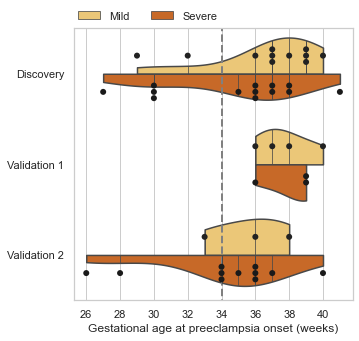

In [10]:
fig, ax = plot_violin_and_swarmplot(df = meta_subj_all.loc[meta_subj_all.case == 1].dropna(subset = ['pe_onset_ga_wk', 'pe_feature']), 
                                    x_name = 'pe_onset_ga_wk', y_name = 'dataset', hue_name = 'pe_feature', orient = 'h', violinplot_palette = 'YlOrBr',
                                    x_label = 'Gestational age at preeclampsia onset (weeks)', y_label = '', split = True, inner = 'sticks',
                                    include_vline = True, line_pos = 34, line_start = -5, line_end = 5)
    
plt.yticks([0,1,2], ['Discovery', 'Validation 1', 'Validation 2'])
#ax.get_legend().remove()
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['Mild', 'Severe'], ncol=2, frameon=0, bbox_to_anchor=(0.55, 1.1))
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
save_figure_pdf(fig, out_path_prefix + 'GA_at_PE_onset.pdf')

# Visualize other known confounding factors
* BMI [Higher risk with increased BMI]
* Maternal age
* Gravidity [Higher risk if nulliparous]

In [11]:
confounding_factors = {'mom_age' : 'Maternal age (years)', 'bmi' : 'Maternal pre-pregnancy BMI', 'gravidity' : 'Gravidity (n)'}
other_confounding_factors_pvals = {}

for ds_name, meta_subj in meta_subj_all.groupby('dataset'):
    other_confounding_factors_pvals[ds_name] = {factor : test_and_adj([(0, 1)], meta_subj, 'case', factor, 'two-sided', use_ttest = False)[0][(0, 1)].round(5) for factor in confounding_factors.keys()}

other_confounding_factors_pvals['gapps']['bmi'] = np.nan #No prepreg BMI collected for this cohort
other_confounding_factors_pvals

{'discovery': {'mom_age': 0.81836, 'bmi': 0.02372, 'gravidity': 0.29319},
 'gapps': {'mom_age': 0.20273, 'bmi': nan, 'gravidity': 0.5209},
 'validation': {'mom_age': 0.16232, 'bmi': 0.45232, 'gravidity': 0.76228}}

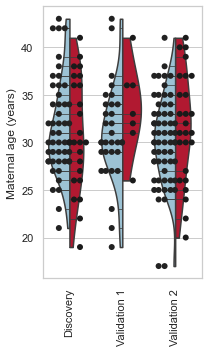

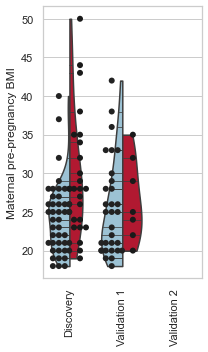

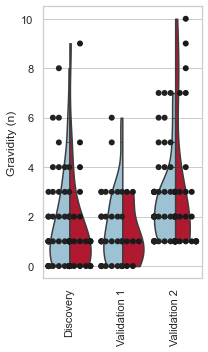

In [12]:
meta_subj_all.bmi = meta_subj_all.bmi.round(0) #For plotting - round to nearest integer

for factor, y_label in confounding_factors.items():
    fig, ax = plot_violin_and_swarmplot(df = meta_subj_all, x_name = 'dataset', y_name = factor, hue_name = 'case', orient = 'v', violinplot_palette = cntrl_pe_palette,
                                            y_label = y_label, x_label = '', split = True, inner = 'sticks', figsize = (3, 5))

    ax.set_xticklabels(['Discovery', 'Validation 1', 'Validation 2'], rotation = 90)
    ax.legend().remove()
    fig.tight_layout()
    
    save_figure_pdf(fig, out_path_prefix + y_label.replace(' ', '_').replace('(', '').replace(')', '') + '.pdf')